### Análise de integridade e qualidade dos dados (Camada RAW/Bronze) - Airline Delay Causes

Esta etapa avalia o `dados_brutos.csv` como ele foi ingerido, sem aplicar correções ou persistir transformações. O objetivo é diagnosticar a “saúde” do dado antes do ETL, identificando falhas de completude, inconsistências, duplicidades e comportamentos anômalos que possam comprometer a etapa de refinamento.

No contexto da Arquitetura Medalhão, este notebook funciona como a camada de observabilidade da RAW/Bronze: documenta evidências e quantifica problemas para orientar decisões e regras do ETL RAW → SILVER (tipagem, tratamento de faltantes, validações e descartes).

A seguir estão os trechos de código em Python responsáveis por gerar os gráficos de diagnóstico, junto da justificativa do que cada métrica mede e como ela apoia a limpeza e padronização na camada SILVER.

<!-- # Análise de Integridade e Qualidade dos Dados (Camada Bronze)
Esta etapa consiste na análise do dado bruto (Raw Data) para identificar a "saúde" da base de dados antes de qualquer processo de ETL. Seguindo a Arquitetura de Medalhão, este notebook cumpre o papel de documentar inconsistências na camada Bronze para orientar a limpeza que ocorrerá na camada Silver.
Abaixo estão listados os listados os códigos em python responsáveis por gerar os gráficos de algumas métricas para nortear a limpeza dos dados na silver e a explicação mais detalhada sobre o motivo do uso de tais gráficos. -->

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('dados_brutos.csv')

df.columns = df.columns.str.strip()

### 1. Verificação de faltantes e completude

Esta etapa mede a presença de valores faltantes no `dados_brutos.csv` (NaN e, quando aplicável, campos textuais vazios). O objetivo é diagnosticar a qualidade do dado ainda na camada RAW/Bronze e gerar evidências para as decisões do ETL RAW → SILVER.

Finalidade: identificar colunas com baixa completude e mapear a gravidade do problema (quantidade e percentual de faltantes), apoiando decisões como descarte de colunas inviáveis ou aplicação de regras de tratamento na SILVER.

Importância para o ETL: não faz sentido propagar para a SILVER colunas sem valor informacional (por exemplo, 100% vazias) ou carregar dados sem definir como tratar faltantes, pois isso compromete consistência, validações e consultas posteriores.

Observação: a coluna `Unnamed: 21` aparece como 100% faltante neste dataset e, portanto, é candidata a descarte no ETL (mantendo-se o arquivo bruto intacto na RAW).

<!-- 
# 1.Verificação dos Dados Nulos e Completude dos Dados
A análise de dados nulos é fundamental para garantir que a Camada Prata (Silver) não contenha lacunas que enviesem as consultas SQL posteriores.

**Finalidade:** Identificar colunas com baixa densidade de dados e decidir entre a exclusão da coluna ou a imputação de valores no ETL.

**Importância para o ETL:** Não há sentido em enviar colunas totalmente vazias ou nulas para o ETL.

**Observação:** Colunas como Unnamed: 21 foram identificadas como 100% nulas e serão descartadas. -->

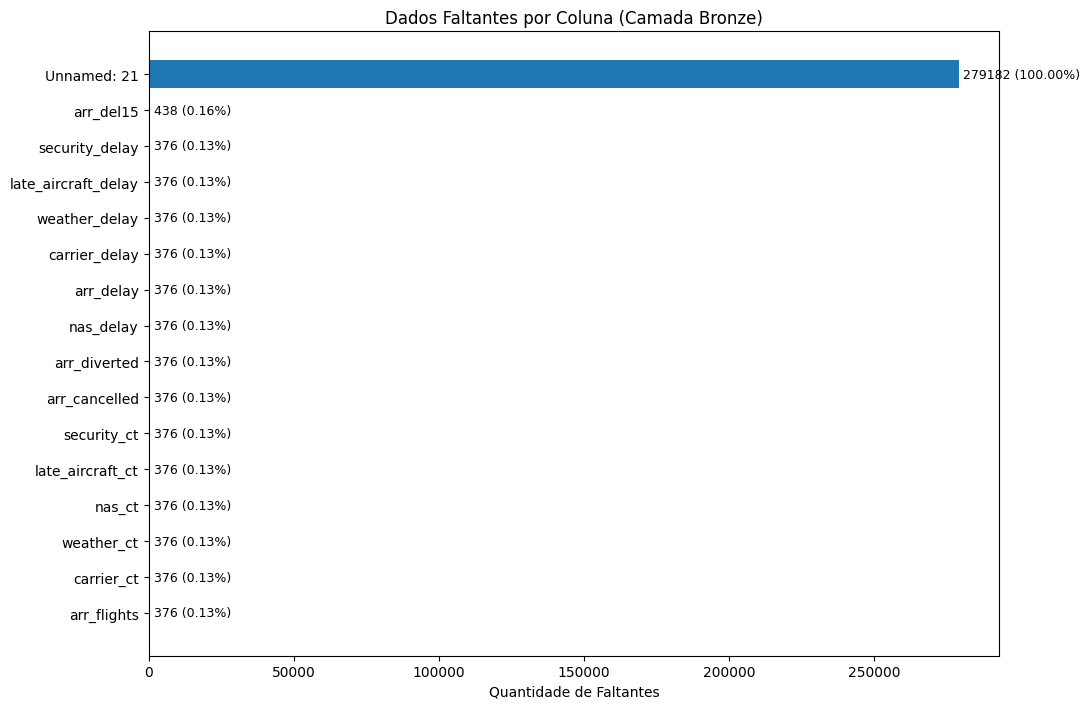

In [ ]:
obj = df.select_dtypes("object")
falt = df.isna() | (obj.fillna("").astype(str).apply(lambda s: s.str.strip().eq("")).reindex(df.columns, axis=1, fill_value=False))

nulos = falt.sum()
pct = nulos / len(df) * 100
s = nulos[nulos > 0].sort_values()

fig, ax = plt.subplots(figsize=(11, max(4, 0.45 * len(s))))
bars = ax.barh(s.index, s.values)
ax.set_title("Dados Faltantes por Coluna (Camada Bronze)")
ax.set_xlabel("Quantidade de Faltantes")
ax.bar_label(bars, labels=[f"{int(v)} ({pct[c]:.2f}%)" for c, v in s.items()], padding=3, fontsize=9)
plt.tight_layout()
plt.show()

# nulos = df.isnull().sum()

# # Gráfico de barras para visualizar falhas nos dados
# plt.figure(figsize=(12, 6))
# nulos[nulos > 0].plot(kind='bar', color='salmon')
# plt.title('Dados Faltantes por Coluna (Camada Bronze)')
# plt.ylabel('Quantidade de Nulos')
# plt.show()

# print(f"Total de linhas com valores nulos: {df.isnull().any(axis=1).sum()}")

### 2. Verificação de registros duplicados

Gráfico: barras (linhas únicas vs duplicadas).

Finalidade: identificar redundância no arquivo bruto, verificando a existência de linhas duplicadas exatamente iguais.

Importância para o ETL: duplicidades na RAW/Bronze podem inflar contagens e somatórios, distorcendo métricas e análises posteriores. Ao quantificar o problema nesta etapa, o ETL RAW → SILVER pode aplicar a regra adequada de deduplicação (ou confirmar que ela não é necessária), mantendo rastreabilidade e consistência dos resultados.

<!-- # 2.Verificação de Registros Duplicados

**Gráfico:** Barras

**Finalidade:** Identificar se há redundância no CSV original(Linhas duplicadas).

**Importância para o ETL:** A existência de duplicados na camada Bronze pode gerar métricas infladas no Dashboard final. O ETL de Raw to Silver será responsável por "limpar esses dados", logo precisamos verificar. -->

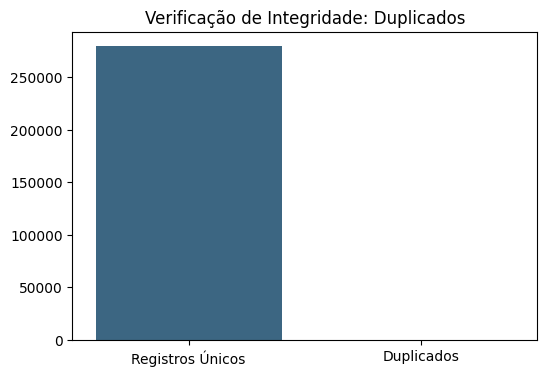

Foram encontrados 0 registros duplicados.


In [ ]:
total_duplicados = df.duplicated().sum()

plt.figure(figsize=(6, 4))
nomes = ['Registros Únicos', 'Duplicados']
valores = [len(df) - total_duplicados, total_duplicados]

sns.barplot(x=nomes, y=valores, hue=nomes, palette='viridis', legend=False)
plt.title('Verificação de Integridade: Duplicados')
plt.show()

print(f"Foram encontrados {total_duplicados} registros duplicados.")

### 3. Verificação de outliers (valores extremos)

Gráfico: box plot.

Finalidade: identificar valores extremos em variáveis numéricas (por exemplo, `arr_delay`) e avaliar se representam erro de registro/unidade, inconsistência de captura, ou eventos reais de cauda longa.

Importância para o ETL: outliers podem distorcer médias, escalas de visualização e modelos analíticos, impactando diretamente a camada GOLD (dashboards e métricas). Ao evidenciar a magnitude e a frequência desses extremos ainda na RAW/Bronze, o ETL RAW → SILVER pode definir regras explícitas de validação e tratamento (manter, truncar, corrigir ou sinalizar).

<!-- # 3.Verificar Outliers

3. Identificação de Outliers (Dados Fora da Curva)

**Gráfico:** Box Plot.

**Finalidade**: Detectar valores extremos (como os atrasos superiores a 400.000 minutos observados) para avaliar se são erros de entrada de dados ou eventos reais de cauda longa.

**Importância para o ETL:** Identificar se há algum dado muito discrepante que possa comprometer nossos dashboards na camada **gold**, por exemplo. -->

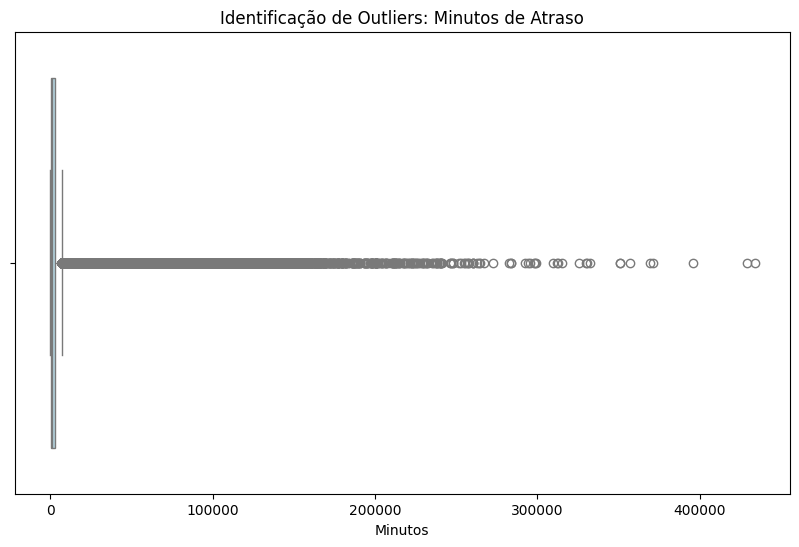

In [4]:
# Analisando outliers na coluna de atraso total
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['arr_delay'], color='lightblue')
plt.title('Identificação de Outliers: Minutos de Atraso')
plt.xlabel('Minutos')
plt.show()

### 4. Análise de distribuição (histograma)

Gráfico: histograma (com escala log no eixo x para lidar com assimetria).

Finalidade: visualizar a distribuição do volume de voos por registro (`arr_flights`), identificando concentração em valores baixos/zero e presença de cauda longa.

Importância para o ETL: entender a ordem de grandeza e a assimetria do volume ajuda a calibrar validações (ex.: não-negatividade, faixas plausíveis), a escolher estratégias de agregação e a evitar distorções de métricas por poucos registros muito grandes. Também fornece insumos para decisões de modelagem/consumo na GOLD (por exemplo, segmentações por porte e tratamento de skew em consultas).

<!-- ## 4. Análise de Distribuição (Histograma)

**Gráfico**: Histograma.

**Finalidade:** Visualizar a concentração do volume de voos (`arr_flights`) por registro.

**Importância para o ETL:** Identificar se a maioria dos registros representa aeroportos de pequeno, médio ou grande porte, o que auxilia na definição de estratégias de particionamento na camada **Gold**. -->

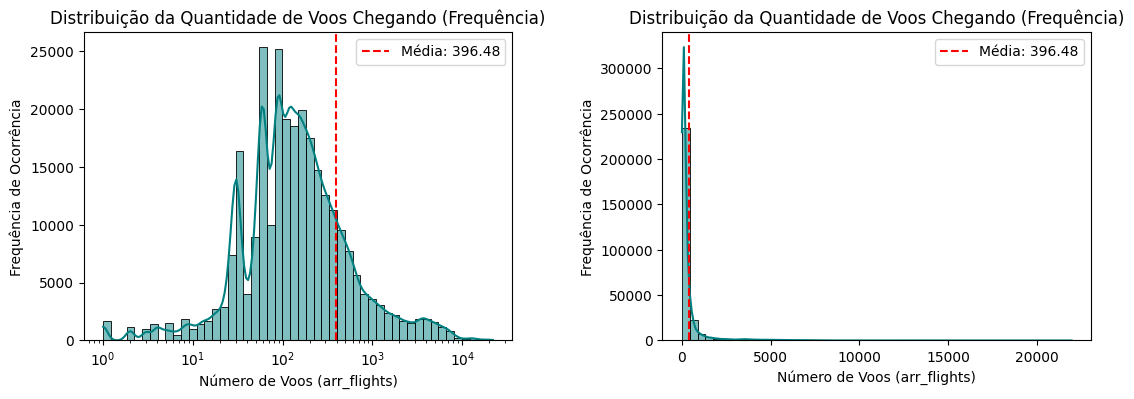

In [ ]:
plt.figure(figsize=(13, 4))
# Log
plt.subplot(1, 2, 1)
sns.histplot(df['arr_flights'].dropna(), bins=50, kde=True, color='teal', log_scale=True)

plt.title('Distribuição da Quantidade de Voos Chegando (Frequência)')
plt.xlabel('Número de Voos (arr_flights)')
plt.ylabel('Frequência de Ocorrência')

plt.axvline(df['arr_flights'].mean(), color='red', linestyle='--', label=f'Média: {df["arr_flights"].mean():.2f}')
plt.legend()

# Linear
plt.subplot(1, 2, 2)
sns.histplot(df['arr_flights'].dropna(), bins=50, kde=True, color='teal')

plt.title('Distribuição da Quantidade de Voos Chegando (Frequência)')
plt.xlabel('Número de Voos (arr_flights)')
plt.ylabel('Frequência de Ocorrência')

plt.axvline(df['arr_flights'].mean(), color='red', linestyle='--', label=f'Média: {df["arr_flights"].mean():.2f}')
plt.legend()

plt.subplots_adjust(wspace=0.35)  # aumenta o espaçamento entre os gráficos
plt.show()


# plt.figure(figsize=(10, 6))

# # Criando o histograma para a coluna de quantidade de voos
# sns.histplot(df['arr_flights'].dropna(), bins=50, kde=True, color='teal',log_scale=True)

# plt.title('Distribuição da Quantidade de Voos Chegando (Frequência)')
# plt.xlabel('Número de Voos (arr_flights)')
# plt.ylabel('Frequência de Ocorrência')

# # Adicionando uma linha para a média, facilitando a análise estatística
# plt.axvline(df['arr_flights'].mean(), color='red', linestyle='--', label=f'Média: {df["arr_flights"].mean():.2f}')
# plt.legend()

# plt.show()

# plt.figure(figsize=(10, 6))

# # Criando o histograma para a coluna de quantidade de voos(Linear)
# sns.histplot(df['arr_flights'].dropna(), bins=50, kde=True, color='teal')

# plt.title('Distribuição da Quantidade de Voos Chegando (Frequência)')
# plt.xlabel('Número de Voos (arr_flights)')
# plt.ylabel('Frequência de Ocorrência')

# plt.axvline(df['arr_flights'].mean(), color='red', linestyle='--', label=f'Média: {df["arr_flights"].mean():.2f}')
# plt.legend()

# plt.show()

### 5. Correlação entre volume e atrasos (heatmap)

Gráfico: heatmap de correlação (Pearson).

Finalidade: mostrar como `arr_flights`, `arr_del15`, `arr_delay` e os atrasos por causa variam juntos, validando se a estrutura do dataset é consistente (total vs componentes).

Importância para o ETL: correlações fora do esperado podem sinalizar problemas de ingestão, tipagem ou dados incompletos, ajudando a direcionar validações e regras no ETL RAW → SILVER.

Observação: correlação não indica causalidade; aqui o uso é como sanity-check de qualidade.

<!-- ## 5. Análise da Correlação de Atrasos

**Gráfico**: matriz de correlação.

**Finalidade:** Visualizar quais colunas se relacionam mais para causar atrasos.

**Importância para o ETL:** Servirá para comparar essa métrica de causa de atraso entre o dado sujo (raw) e o dado limpo na silver. -->

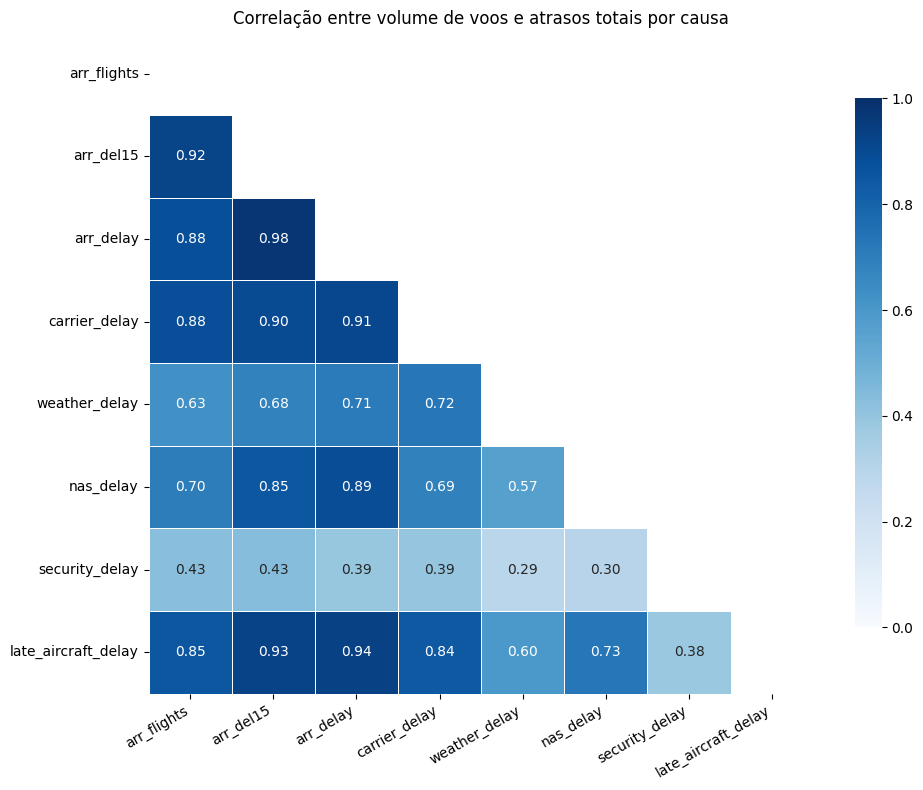

In [3]:
cols = [
    "arr_flights", "arr_del15", "arr_delay",
    "carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay"
]
cols = [c for c in cols if c in df.columns]

X = df[cols].apply(pd.to_numeric, errors="coerce")
corr = X.corr(method="pearson")

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr, mask=mask, annot=True, fmt=".2f",
    cmap="Blues", vmin=0, vmax=1, linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlação entre volume de voos e atrasos totais por causa")
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()